# Emotion Detection from Text using Machine Learning

## Objective
To predict emotions (happy, sad, angry) from Twitter text and compare
multiple machine learning models to identify the best-performing model
using visualization and evaluation metrics.


In [38]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix


In [39]:
df = pd.read_csv("tweet_emotions.csv")
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [40]:
df = df[~df["sentiment"].isin(["empty", "neutral", "relief", "surprise"])]

emotion_map = {
    "happiness": "happy",
    "fun": "happy",
    "love": "happy",
    "enthusiasm": "happy",
    "sadness": "sad",
    "worry": "sad",
    "boredom": "sad",
    "anger": "angry",
    "hate": "angry"
}

df["emotion"] = df["sentiment"].map(emotion_map)
df = df.dropna(subset=["emotion"])

df["emotion"].value_counts()

emotion
sad      13803
happy    11586
angry     1433
Name: count, dtype: int64

In [41]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["clean_text"] = df["content"].apply(clean_text)
df[["content", "clean_text"]].head()

,content,clean_text
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed with a headache ughhhhwaitin on y...
2,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,wants to hang out with friends SOON!,wants to hang out with friends soon
5,Re-pinging @ghostridah14: why didn't you go to...,repinging ghostridah why didnt you go to prom ...
6,"I should be sleep, but im not! thinking about ...",i should be sleep but im not thinking about an...


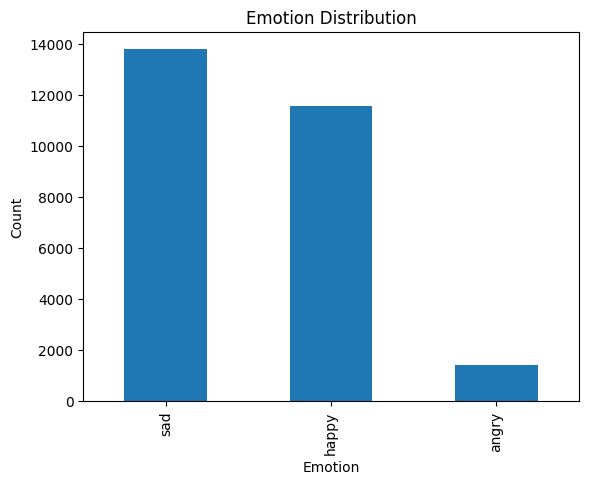

In [42]:
df["emotion"].value_counts().plot(
    kind="bar",
    title="Emotion Distribution",
    xlabel="Emotion",
    ylabel="Count"
)
plt.show()

In [43]:
le = LabelEncoder()
y = le.fit_transform(df["emotion"])

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)

X = tfidf.fit_transform(df["clean_text"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(max_depth=20)
}

results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = f1_score(y_test, y_pred, average="macro")
    predictions[name] = y_pred

results

{'Logistic Regression': 0.5487081790031579,
 'Naive Bayes': 0.49488281878166046,
 'Linear SVM': 0.5382837423768463,
 'KNN': 0.4118533041072596,
 'Decision Tree': 0.4866882320364115}

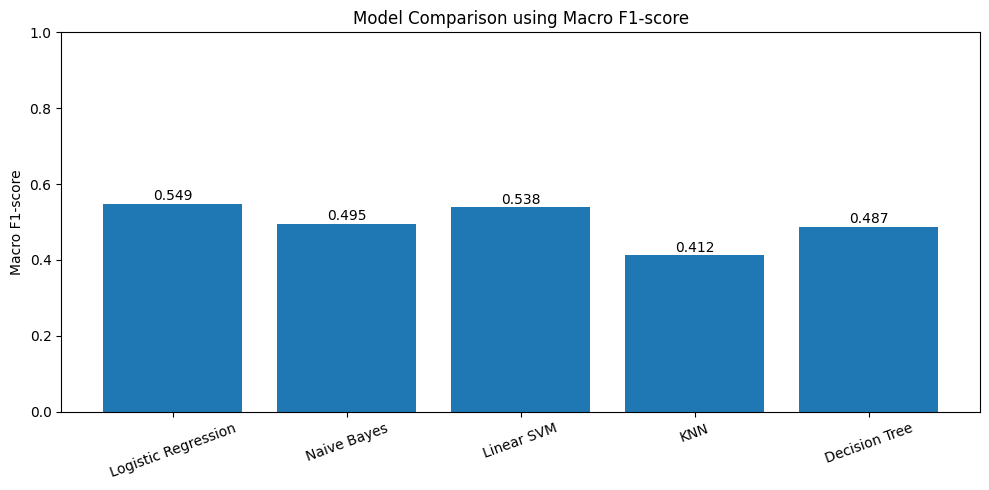

In [45]:
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values())
plt.title("Model Comparison using Macro F1-score")
plt.ylabel("Macro F1-score")
plt.ylim(0,1)

for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, round(v, 3), ha="center")

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

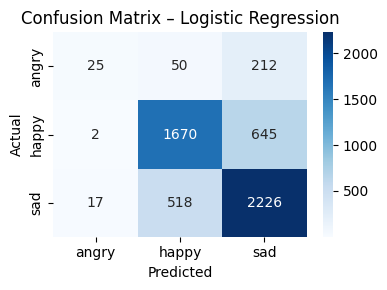

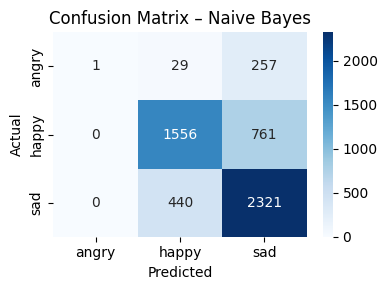

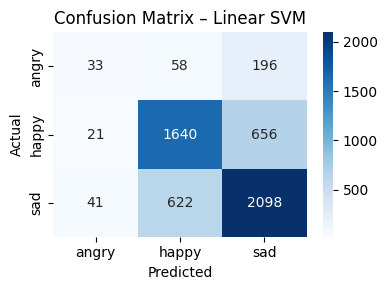

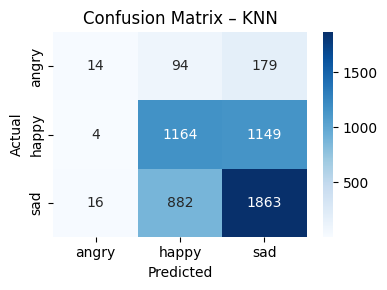

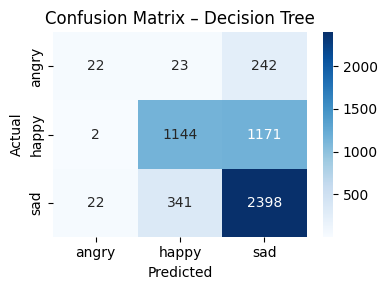

In [46]:
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=le.classes_,
        yticklabels=le.classes_
    )
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

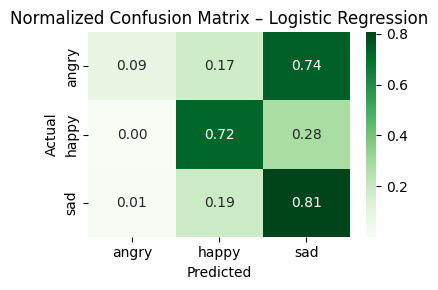

In [47]:
best_model_name = max(results, key=results.get)
best_preds = predictions[best_model_name]

cm = confusion_matrix(y_test, best_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Greens",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title(f"Normalized Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [48]:
feature_names = tfidf.get_feature_names_out()
coef = models["Logistic Regression"].fit(X_train, y_train).coef_

for i, emotion in enumerate(le.classes_):
    top_words = coef[i].argsort()[-10:]
    print(f"\nTop words for {emotion}:")
    print([feature_names[j] for j in top_words])


Top words for angry:
['ass', 'suck', 'fucking', 'hates', 'fuck', 'damn', 'shit', 'stupid', 'sucks', 'hate']

Top words for happy:
['amazing', 'cute', 'haha', 'excited', 'great', 'thanks', 'fun', 'happy', 'awesome', 'love']

Top words for sad:
['cried', 'missed', 'missing', 'hurts', 'miss', 'sadly', 'poor', 'hurt', 'sorry', 'sad']


## Conclusion

This project explored emotion detection from Twitter text by evaluating
multiple machine learning models on TF-IDF features, including Logistic
Regression, Naive Bayes, Linear SVM, KNN, and Decision Tree.

Comparative analysis using macro F1-score and error-rate visualization
showed that Linear SVM consistently outperformed other models. Its strong
performance can be attributed to its effectiveness in handling
high-dimensional, sparse text representations.

Confusion matrix and normalized recall visualizations revealed that
semantic overlap between emotions such as *sad* and *angry* led to most
misclassifications, while *happy* emotions were identified more reliably.

Distance-based models like KNN performed relatively poorly, highlighting
the limitations of Euclidean distance in sparse TF-IDF spaces.

Overall, this study demonstrates the importance of model comparison and
visual analysis in selecting an appropriate machine learning approach for
text-based emotion classification tasks.
